In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

## Data

### Download

In [4]:
!git clone https://github.com/rois-codh/kmnist

Cloning into 'kmnist'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 173 (delta 6), reused 0 (delta 0), pack-reused 161
Receiving objects: 100% (173/173), 395.89 KiB | 734.00 KiB/s, done.
Resolving deltas: 100% (93/93), done.


In [5]:
!python kmnist/download_data.py 

Please select a download option:
1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)
2) Kuzushiji-49 (49 classes, 28x28, 270k examples)
3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)
> 3
Please select a download option:
1) Folders of images (.tar)
> 1
100% 316690/316691 [00:31<00:00, 9916.98KB/s] 
All dataset files downloaded!


In [0]:
!tar xf kkanji.tar

### Visualize

In [0]:
PATH = Path('kkanji2')

In [0]:
!ls {PATH}/U+4E71/

0d0cd162e69ced42.png  86bccf560b6a3c77.png  b74ea5507048e943.png
1500e9817c2c8d20.png  87c65a81104d03e1.png  cf8e3b2fb2c33359.png
2078e820d3ba13ef.png  89d6bae1597f975e.png  dd63886f937c6729.png
24a2db033e17721a.png  8ff3e935382ba727.png  e2a088d6c72fceaf.png
4fa18bf5d5716a01.png  94912ba52c0f3549.png  e599c1b8f9f734de.png
5233ad6af04eaf93.png  95748e8c6cf8305b.png  e6a62b93f97686e1.png
5461035f48481131.png  963261cec89cb3ad.png  f2be1e4916bea265.png
5ab26ea400ee2a62.png  9db0244b361a57f0.png  fb8adbc57da7725b.png
5cbff0c6a5d9e4d4.png  a26249d4b7749013.png  fc4c3a74d022747b.png
6049a2200c5e8722.png  abede8f9fd774642.png
719a72d413046402.png  b1d450b36778715a.png


In [0]:
imdata = plt.imread(str(PATH/'U+4E71/0d0cd162e69ced42.png'))

In [0]:
imdata = io.imread(str(PATH/'U+4E71/0d0cd162e69ced42.png'))

In [0]:
imdata/256

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01568627, 0.00392157,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.07843137, 0.01960784,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [0]:
imdata.shape

(64, 64)

In [0]:
np.expand_dims(imdata, axis=-1).shape

(64, 64, 1)

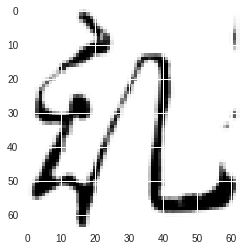

In [0]:
plt.imshow(imdata)

Scan filenames

In [7]:
filenames = []
labels = []
for p in tqdm(PATH.glob('*/*.png')):
    fname = str(p)
    filenames.append(fname)
    label = fname.split('/')[1]
    labels.append(label)
    
size = len(filenames)

140424it [00:01, 131150.28it/s]


In [0]:
classes = list(set(labels))

ctoi = dict((c, i) for i, c in enumerate(classes))
itoc = dict((i, c) for i, c in enumerate(classes))

In [0]:
class_size = len(classes)

In [0]:
itoc[1], ctoi['U+6D17']

('U+5BE1', 2698)

In [0]:
labels = [ctoi[lbl] for lbl in labels]

In [0]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img, cmap='gray') # cmap='binary'

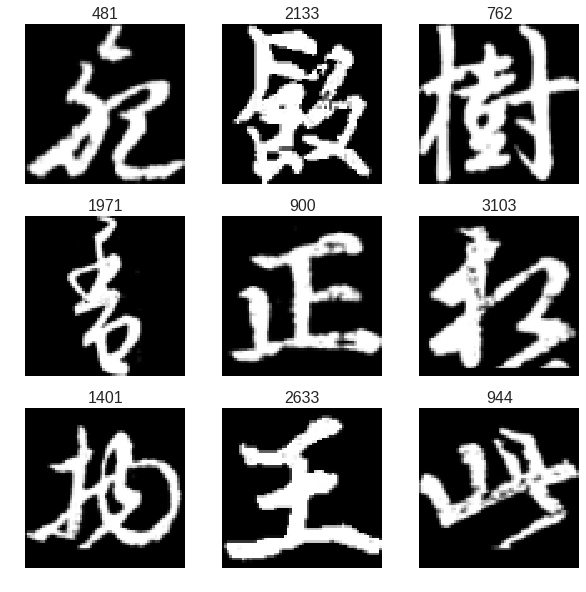

In [13]:
idxs = [np.random.randint(0, size-1) for i in range(9)]
imspaths = [filenames[i] for i in idxs]
titles = [labels[i] for i in idxs]

plots_from_files(imspaths, rows=3, titles=titles, figsize=(10, 10))

### DataLoader 

In [0]:
bs = 128

In [11]:
data = np.zeros((len(filenames), 1, 64, 64), dtype=np.float)
for index, fname in tqdm(enumerate(filenames)):
    imdata = io.imread(fname)
    # normalize the data
    normalized = imdata / 256
    data[index] = np.expand_dims(normalized, axis=0) # shape (1, 64, 64)
    
data.shape

140424it [01:50, 1269.52it/s]


(140424, 1, 64, 64)

normalize the data to be between 0 and 1

In [0]:
np.save(PATH/'data.pkl', data)
np.save(PATH/'labels.pkl', labels)

In [0]:
data = np.load(PATH/'data.pkl')
labels = np.load(PATH/'labels.pkl')

In [0]:
data_cuda   = torch.FloatTensor(data).cuda()
labels_cuda = torch.LongTensor(labels).cuda()

In [14]:
valid_offset = int(data_cuda.shape[0] * 0.9)

X_train, y_train = data_cuda[: valid_offset], labels_cuda[: valid_offset]
X_valid, y_valid = data_cuda[valid_offset: ], labels_cuda[valid_offset: ]

X_train.shape, len(y_train), X_valid.shape, len(y_valid)

(torch.Size([126381, 1, 64, 64]),
 126381,
 torch.Size([14043, 1, 64, 64]),
 14043)

In [0]:
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)

In [0]:
valid_ds = torch.utils.data.TensorDataset(X_valid, y_valid)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs, shuffle=True)

## Model

In [0]:
def conv2d(ni, nf, k=3, s=2, p=1): return nn.Conv2d(ni, nf, kernel_size=k, stride=s, padding=p)

In [0]:
def upsample(ni, nf, k=3, s=2, p=1, op=0): return nn.ConvTranspose2d(ni, nf, kernel_size=k, stride=s, padding=p, output_padding=op)

In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

In [0]:
class ResnetBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv2d(nf, nf, s=1)
        self.batchnorm = nn.BatchNorm2d(nf)
        self.relu = nn.ReLU(True)
        self.conv2 = conv2d(nf, nf, s=1)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm(out)
        out = self.relu(out)
        out = self.conv2(out)
        return x + out

In [0]:
def conv_res(ni, nf): return nn.Sequential(conv2d(ni, nf), ResnetBlock(nf))

In [0]:
def up_res(ni, nf): return nn.Sequential(upsample(ni, nf, op=1), ResnetBlock(nf))

In [0]:
def create_encoder(image_size=64, latent_dim=4):
    channels = [1, 4, 8, 16, 32]
    layers = []
    layers.append(conv_res(channels[0], channels[1]))  # (bs, 32, 32)
    layers.append(conv_res(channels[1], channels[2]))  # (bs, 16, 16)
    layers.append(conv_res(channels[2], channels[3]))  # (bs, 8, 8)
    layers.append(conv_res(channels[3], channels[4]))  # (bs, 4, 4)
    return nn.Sequential(*layers)

In [0]:
def create_decoder(image_size=64, latent_dim=4):
    channels = [32, 16, 8, 4, 1]
    layers = []
    # use upsampling
    layers.append(up_res(channels[0], channels[1])) # (bs, 16, 16)
    layers.append(up_res(channels[1], channels[2])) # (bs, 8, 8)
    layers.append(up_res(channels[2], channels[3])) # (bs, 4, 4)
    layers.append(up_res(channels[3], channels[4])) # (bs, 1, 1)
    return nn.Sequential(*layers)

In [0]:
enc = create_encoder()

In [0]:
dec = create_decoder()

In [0]:
enc

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ResnetBlock(
      (conv1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ResnetBlock(
      (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ResnetBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=

In [50]:
dec

Sequential(
  (0): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ResnetBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (1): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ResnetBlock(
      (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (2): Sequential(
    (0): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),

### Classification Model

In [0]:
class Classifier(nn.Module):
    def __init__(self, enc, class_size):
        super().__init__()
        self.enc = enc
        self.flatten = Flatten()                          # (bs, 16 * 32)
        self.relu = nn.ReLU(True)
        self.drop = nn.Dropout()
        self.lin  = nn.Linear(in_features= 512, out_features=class_size)
        
    def forward(self, X):
        y = self.enc(X)
        y = self.flatten(y)
        y = self.relu(y)
        y = self.drop(y)
        return self.lin(y)

In [0]:
model = Classifier(enc, class_size).cuda()

In [0]:
lr=2e-2

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in train_dl]

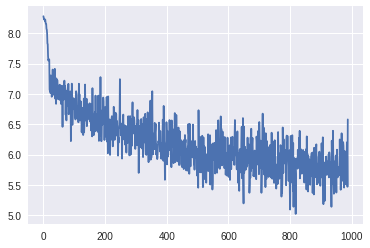

In [42]:
plt.plot(losses);

### AutoEncoder Model

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.enc = encoder
        self.dec = decoder
        
    def forward(self, X):
        y = self.enc(X)
        y = self.dec(y)
        return y

In [0]:
enc = create_encoder()
dec = create_decoder()

In [0]:
model = AutoEncoder(enc, dec).cuda()

In [0]:
lr=2e-2

In [0]:
loss_func = nn.L1Loss()

In [0]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
train_ds = torch.utils.data.TensorDataset(X_train, X_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)

In [0]:
epochs = 10

In [32]:
valid_losses = []
for epoch in tqdm(range(epochs)):
    losses = [update(x,y,lr) for x,y in train_dl]
    y_hat = model(X_valid)
    valid_loss = loss_func(y_hat, X_valid)
    valid_losses.append(valid_loss.item())

 40%|████      | 4/10 [09:37<14:26, 144.45s/it]

RuntimeError: ignored

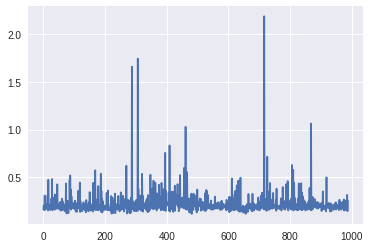

In [33]:
plt.plot(losses)

### AutoEncoder

In [0]:
#model = nn.Sequential(enc, dec).cuda()